## Discretization

Discretization is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values. Discretization is also called **binning**, where bin is an alternative name for interval.


### Discretization helps handle outliers and may improve the value spread in skewed variables

Discretization helps handle outliers by placing these values into the lower or higher intervals, together with the remaining inlier values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval / bucket. In addition, by creating appropriate bins or intervals, discretization can help spread the values of a skewed variable across a set of bins with an equal number of observations.


### Discretization approaches

There are several approaches to transforming continuous variables into discrete ones. Discretization methods fall into 2 categories: **supervised and unsupervised**. Unsupervised methods do not use any information, other than the variable distribution, to create the contiguous bins in which the values will be placed. Supervised methods typically use target information in order to create the bins or intervals.


####  Unsupervised discretization methods

- Equal width discretisation
- Equal frequency discretization
- K-means discretization

#### Supervised discretization methods

- Discretization using decision trees


In this lecture, I will describe **equal frequency discretization.


## Equal frequency discretization

Equal frequency discretization divides the scope of possible values of the variable into N bins, where each bin carries the same amount of observations. This is particularly useful for skewed variables, as it spreads the observations over the different bins equally. We find the interval boundaries by determining the quantiles.

Equal frequency discretization using quantiles consists of dividing the continuous variable into N quantiles, where N to be defined by the user.

Equal frequency binning is straightforward to implement, and by spreading the values of the observations more evenly, it may help boost the algorithm's performance. This arbitrary binning may also disrupt the relationship with the target.

## Titanic dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv('../../titanic.csv', usecols=['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

In [4]:
def impute_na(data, variable):
    # function to fill NA with a random sample

    df = data.copy()

    # random sampling
    df[variable+'_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample

    return df[variable+'_random']

In [5]:
# replace NA in both train and test sets

X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

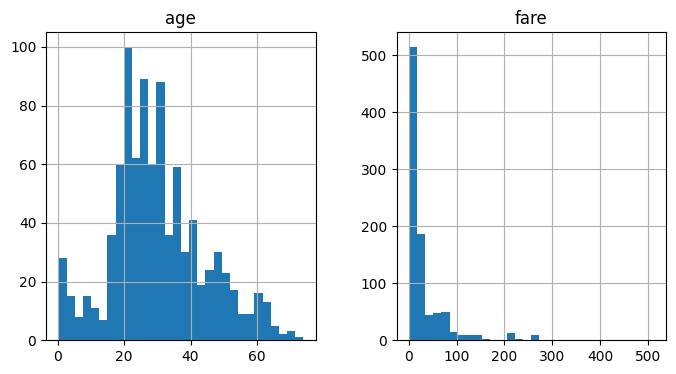

In [6]:
# let's explore the distribution of age

X_train[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

## Equal frequency discretization with pandas

The interval limits are the quantile limits. We can find those out with pandas qcut.

In [7]:
# let's use pandas qcut (quantile cut) and I indicate that
# we want 10 bins.

# retbins = True indicates that I want to capture the limits
# of each interval (so I can then use them to cut the test set)

Age_disccretised, intervals = pd.qcut(
    X_train['age'], 10, labels=None, retbins=True, precision=3, duplicates='raise')

pd.concat([Age_disccretised, X_train['age']], axis=1).head(10)

,age,age
501,"(0.166, 16.0]",13.0
588,"(0.166, 16.0]",4.0
402,"(28.0, 31.0]",30.0
1193,"(36.0, 42.0]",40.5
686,"(20.0, 22.0]",22.0
971,"(36.0, 42.0]",39.0
117,"(28.0, 31.0]",30.0
540,"(0.166, 16.0]",2.0
294,"(42.0, 50.0]",49.0
261,"(31.0, 36.0]",35.0


We can see in the above output how by discretising using quantiles, we placed each Age observation within one interval. For example, age 30 was placed in the 28-31 interval, whereas age 49 was placed into the 42-50 interval. 

Note how the interval widths are different.

We can visualise the interval cut points below:

In [8]:
intervals

array([ 0.1667, 16.    , 20.    , 22.    , 25.    , 28.    , 31.    ,
       36.    , 42.    , 50.    , 74.    ])

And because we generated the bins using the quantile cut method, we should have roughly the same amount of observations per bin. See below.

In [9]:
# roughly the same number of passengers per interval

Age_disccretised.value_counts()

(0.166, 16.0]    106
(31.0, 36.0]     106
(16.0, 20.0]      92
(22.0, 25.0]      92
(25.0, 28.0]      92
(28.0, 31.0]      90
(42.0, 50.0]      90
(36.0, 42.0]      85
(20.0, 22.0]      82
(50.0, 74.0]      81
Name: age, dtype: int64

In [10]:
# we can also add labels instead of having the interval boundaries, to the bins, as follows:

labels = ['Q'+str(i) for i in range(1,11)]
labels

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']

In [11]:
Age_disccretised, intervals = pd.qcut(X_train['age'], 10, labels=labels,
                                      retbins=True,
                                      precision=3, duplicates='raise')

Age_disccretised.head()

501     Q1
588     Q1
402     Q6
1193    Q8
686     Q3
Name: age, dtype: category
Categories (10, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' ... 'Q7' < 'Q8' < 'Q9' < 'Q10']

In [12]:
# to apply the intervals to the test set, we need to extend
# the limits of the outer bins to -inf and +inf, so that if
# in the test set, there are smaller or bigger values than the 
# minimum or maximum values in the train set, they can be 
# accomodated in the outer intervals. 
# Otherwise, they will be replaced by NaN.

# Prepend/Append infinities to accommodate outliers
intervals[0] = float("-inf")
intervals[len(intervals) - 1] = float("inf")

intervals

array([-inf,  16.,  20.,  22.,  25.,  28.,  31.,  36.,  42.,  50.,  inf])

In [13]:
# to transform the test set:
# we use pandas cut method (instead of qcut) and
# pass the quantile edges calculated in the training set

X_test['Age_disc_label'] = pd.cut(x = X_test['age'], bins=intervals, labels=labels)
X_test['Age_disc'] = pd.cut(x = X_test['age'], bins=intervals)

X_test.head(10)

,age,fare,Age_disc_label,Age_disc
1139,38.0,7.8958,Q8,"(36.0, 42.0]"
533,21.0,21.0000,Q3,"(20.0, 22.0]"
459,42.0,27.0000,Q8,"(36.0, 42.0]"
1150,3.0,14.5000,Q1,"(-inf, 16.0]"
393,25.0,31.5000,Q4,"(22.0, 25.0]"
1189,4.0,16.7000,Q1,"(-inf, 16.0]"
5,48.0,26.5500,Q9,"(42.0, 50.0]"
231,52.0,30.5000,Q10,"(50.0, inf]"
330,57.0,13.0000,Q10,"(50.0, inf]"
887,31.0,8.1125,Q6,"(28.0, 31.0]"


In [14]:
X_test['Age_disc_label'].isnull().sum()

0

<Axes: >

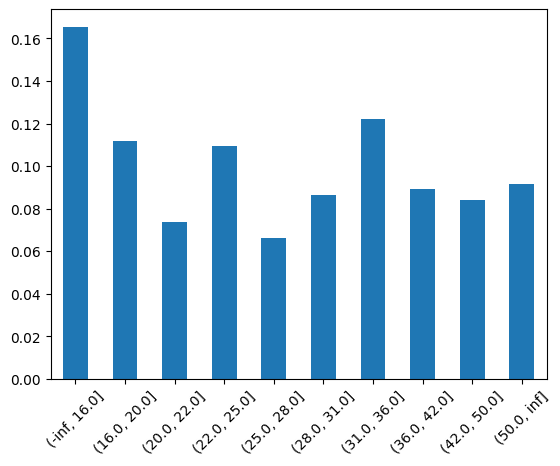

In [15]:
# let's check that we have equal frequency (equal number of observations per bin)
X_test['Age_disc'].value_counts(normalize=True).sort_index().plot.bar(rot=45)

If some intervals have less observations, which can happen with skewed distributions, to make the value spread more homogeneous, we could try using less intervals.